##### <h1 style="text-align:center;"> Classification de films en fonction de leur genre à partir de l'affiche</h1>
<h3 style="text-align:center;">- Alex Fauduet, Virginie Loison, Maxime Poli, Nicolas Schlegel -</h3>


# Récupération et nettoyage des données

Utilise les DataFrame de Pandas pour stocker les données. Attention: ajouter une différenciation par date possible pour supprimer les films pas encore sortis. Souvent n'ont pas une vraie affiche mais juste une photo ce qui faussera les résultats.

In [2]:
%matplotlib inline 

from pathlib import Path
from urllib.request import urlretrieve
from tqdm import tqdm  # barre de chargement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import imageio
import skimage

In [37]:
def database_download(savelocation, dataset, nb=None):
    """Downloads the database from the given links in the dataset"""
    path = Path(savelocation)
    if not path.exists():
        path.mkdir()
    not_found = []
    print('Posters database downloading')
    generator = dataset.iterrows() if nb is None else dataset.head(n=nb).iterrows()
    length = len(dataset) if nb is None else nb
    for index, row in tqdm(generator, total=length):
        current_name = str(index)+'.jpg'
        jpgname = path / current_name
        try:
            if not Path(jpgname).is_file():
                urlretrieve(row.poster, Path(jpgname))
        except Exception:  # Mettre le nom de l'exception possible
            not_found.append(index)
    print('Database downloaded')
    return not_found

In [38]:
SAVELOCATION = 'posters/'
RAW_MOVIES = pd.read_csv('poster_data.csv')
TODAY = pd.Timestamp.today()

# RAW_MOVIES.profile_report()

On nettoie la base de données en ne gardant que les films ayant un titre, une date de sortie, au moins un genre et un poster. On enlève les films pas encore sortis. Voir quels genres supprimer.
Choisir un échantillon d'entraînement à partir des films restants. Pas forcément tout faire au hasard: on a un training set où certains genres sont bien plus représentés.

In [39]:
MOVIES = RAW_MOVIES.dropna(
    subset=['title', 'release_date', 'genre_1', 'poster']).drop(
        RAW_MOVIES[RAW_MOVIES['release_date'].map(pd.Timestamp) > TODAY].index)
# MOVIES.profile_report()

In [40]:
def genre_count(movies):
    """Prints the genres (first category) and the number of appearences"""
    genre_list = movies.genre_1.unique()
#     for genre in np.append(movies.genre_2.unique(), movies.genre_3.unique()):
#         if genre not in genre_list:
#             np.append(genre_list, genre)
    for label in genre_list:
        occurences = len(movies[movies['genre_1'] == label])
        print(label, occurences)
        
# genre_count(MOVIES)

In [41]:
MOVIES.to_csv('clean_poster_data.csv')
not_found = database_download(SAVELOCATION, MOVIES, nb=50)
print(not_found)

  0%|          | 0/50 [00:00<?, ?it/s]

Posters database downloading


100%|██████████| 50/50 [00:05<00:00,  9.73it/s]

Database downloaded
[]


# Preprocessing 
Traite les données

In [75]:
def get_id(path):
    """Gets the id from the Pathlib path"""
    filename = path.parts[-1]
    index_f = filename.rfind(".jpg")
    return int(filename[:index_f])


def show_img(dataset, posters, labels, ids, index):
    """Shows the image with id at index position in ids"""
    title = dataset.at[ids[index], 'title']
    genre = dataset.at[ids[index], 'genre_1']
#     genres = [dataset.at[id,'genre_'+i] for i in ['1','2','3']]
    plt.imshow(posters[index])
    plt.title('{} \n {}'.format(title, genre))
    print('Indice du film: ', ids[index])
    print('Genre conservé: ', labels[index])
    plt.show()


def preprocess(img, size=(150, 100, 3)):
    """Normalizes the image"""
    img = skimage.transform.resize(img, size)
    img = img.astype(np.float32)
#     img = (img / 127.5) -1
    return img

In [76]:
def prepare_data(path, dataset, size=(150, 100, 3), save=True):
    """Generates the data to be used by the neural network"""
    print('Generating dataset...')
    genre_list = dataset.genre_1.unique()
    nb_genres = len(genre_list)
    inv_genre = {genre_list[k]: k for k in range(nb_genres)}
    image_glob = Path(path).glob("*.jpg")
    posters, genres, ids = [], [], []
    for path in tqdm(image_glob):
        try:
            # Meilleure gestion d'erreur à faire
            posters.append(preprocess(imageio.imread(path), size))
            index = get_id(path)
            vect_genre = np.zeros(nb_genres, dtype = int)
            # Rajoute un 1 à l'indice correspondant à la position
            # du premier genre de ce film dans la liste des genres
            vect_genre[inv_genre[dataset.at[index, 'genre_1']]] = 1
            ids.append(index)
            genres.append(vect_genre)
        except Exception as e:
            print(e)
    if save:
        np.save('numpy_posters', posters)
        np.save('numpy_genres', genres)
        np.save('numpy_ids', ids)
    print('Done.')
    return posters, genres, ids

Indice du film:  962
Genre conservé:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


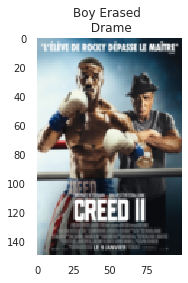

['Drame' 'Documentaire' 'Epouvante-horreur' 'Biopic' 'Comédie'
 'Fantastique' 'Western' 'Aventure' 'Divers' 'Animation' 'Thriller'
 'Action' 'Policier' 'Romance' 'Espionnage' 'Comédie dramatique' 'Guerre'
 'Comédie musicale' 'Sport event' 'Famille' 'Bollywood' 'Musical'
 'Science fiction' 'Historique' 'Opera' 'Concert' 'Judiciaire' 'Erotique'
 'Classique' 'Péplum' 'Expérimental' 'Arts Martiaux' 'Dessin animé']
         title release_date genre_1 genre_2 genre_3  \
1178  Creed II   2019-01-09   Drame  Action     NaN   

                                                 poster  
1178  http://fr.web.img5.acsta.net/pictures/18/11/27...  


In [83]:
# X,Y,ID = prepare_data(SAVELOCATION, MOVIES)
X = np.load('numpy_posters.npy')
Y = np.load('numpy_genres.npy')
ID = np.load('numpy_ids.npy')
show_img(MOVIES, X, Y, ID, 68)
print(MOVIES.genre_1.unique())
print(MOVIES[MOVIES.title == 'Creed II'])